# Analysis findings

## Goal: analyze how four treatments (Capomulin, Infubinol, Ketapril, and Placebo) compare.
### Additionally, pivot tables were created showing results for all treatments:

+ Capomulin
+ Ceftamin
+ Infubinol
+ Ketapril
+ Naftisol
+ Placebo 	
+ Propriva 	
+ Ramicane
+ Stelasyn
+ Zoniferol

### Overview of additional pivot tables

+ Pivot table for tumor volume changes for all trial treatments
+ Pivot table for metastatic changes over time for all trial treatments
+ Pivot table for absolute survival rates per timepoint for all trial treatments
+ Pivot table for relative survival rates per timepoint for all trial treatments

## Findings for selected treatments (Capomulin, Infubinol, Ketapril, Placebo)

+ On average, tumor volume went down for mice treated with Capomuin (tumor volume went down by 19%). 
  All other treatments show a raise in tumor volume, varying from 46% to 57%.
+ On average, survival rates are highest when treated with Capomulin (84%). 
  All other treatments show a much lower survival rate, varying from 44% to 36%. 
+ On average, Capomulin shows the lowest number of metastatic sites (1.5). 
  However, one should take into account that the SE appears to be quite large (0.2, over 10% of 1.50. 
  You might want to run more tests. 
  On the other hand, treatment with Capomulin resulted in a 19% decrease in tumor volume, 
  which seems to indicate that Capomulin does have a positive effect.    

## Data preparation

In [38]:
# Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [39]:
# Load mouse data into dataframe
input_file = input("Enter the name of the mouse data file you want to analyze (without extension): ") + ".csv"
# Set file path (input file should be located on the same level as the folder raw_data)
mouse_data_file = os.path.join('raw_data', input_file) #mouse_drug_data
# Create dataframe
mouse_df = pd.read_csv(mouse_data_file)
mouse_df.head()

Enter the name of the mouse data file you want to analyze (without extension): mouse_drug_data


,Mouse ID,Drug
0,f234,Stelasyn
1,x402,Stelasyn
2,a492,Stelasyn
3,w540,Stelasyn
4,v764,Stelasyn


In [40]:
# Load trial data into dataframe
input_file = input("Enter the name of the trial data file you want to analyze (without extension): ") + ".csv"
# Set file path (input file should be located on the same level as the folder raw_data)
trial_data_file = os.path.join('raw_data', input_file) #clinicaltrial_data
# Create dataframe
trial_df = pd.read_csv(trial_data_file)
trial_df.head()

Enter the name of the trial data file you want to analyze (without extension): clinicaltrial_data


,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites
0,b128,0,45.0,0
1,f932,0,45.0,0
2,g107,0,45.0,0
3,a457,0,45.0,0
4,c819,0,45.0,0


In [41]:
# Delete mice with more than one treatment
x = mouse_df[mouse_df.duplicated(["Mouse ID"], keep=False)]["Mouse ID"].unique()
x.tolist()
if len(x) != 0:
    mouse_df = mouse_df[~mouse_df["Mouse ID"].isin(x)]

In [42]:
# Merge mouse and trial data
merge_df = pd.merge(trial_df, mouse_df, on = "Mouse ID", how = "inner")
merge_df.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug
0,b128,0,45.000000,0,Capomulin
1,b128,5,45.651331,0,Capomulin
2,b128,10,43.270852,0,Capomulin
3,b128,15,43.784893,0,Capomulin
4,b128,20,42.731552,0,Capomulin


In [ ]:
# After merging, you should check whether there's any rows having:
# - the same combination for Mouse ID, Timepoint and Drug but different values for either 
#   Tumor Volume (mm3) or Metastatic Sites
# If so, these rows should be deleted

In [43]:
# Standard list with treatments we'll be analyzing
drug_list = ["Capomulin", "Infubinol", "Ketapril", "Placebo"]

In [ ]:
# (Optional) create new list of treatments to be analyzed
full_drug_list = []
for item in merge_df["Drug"].unique():
    full_drug_list.append(item)
# Select treatments to be analyzed
print(f"Current analysis is done for these treatments: {[x for x in drug_list]}")
create_new_list = input("Type Y for new analysis")
if create_new_list == "Y":
    print(f"""Available for analysis:
        {[x for x in full_drug_list]}""")
    new_list = input("Enter treatments, separate multiple values by a comma")
    drug_list = list(set(new_list.split(",")))
print(f"New analysis will be done for these treatments: {[x for x in drug_list]}")

Current analysis is done for these treatments: ['Capomulin', 'Infubinol', 'Ketapril', 'Placebo']


In [44]:
# There should not be any gaps in Timepoints
# In this case, Timepoints are an arithmetic progression
# So you can check the sum of the arithmetic progression against the sum of the Timepoints per mouse
# Both sums should be equal. IF not, there's a gap and you should delete the trial data for all mice involved.
# Sum of interval per mouse = nr of timepoints*0.5*(first value + last value)
interval_check = merge_df.groupby(["Mouse ID"], as_index=False)["Timepoint"].agg(["sum","count","first","last"])
interval_check = interval_check.reset_index()
interval_check["Arithmetic sum"] = 0.5*interval_check["count"]*(interval_check["first"]+interval_check["last"])

x = interval_check.loc[~(interval_check["sum"] == interval_check["Arithmetic sum"])]
gap_list = []
for mouse in x["Mouse ID"]:
    gap_list.append(mouse)
merge_df = merge_df[~merge_df["Mouse ID"].isin(gap_list)]

## Analysis

### Tumor volume over time for all trial treatments

In [59]:
# Calculate mean and SE over mean for tumor volume change per treatment
tumor_volume_average = merge_df.groupby(["Drug", "Timepoint"], as_index=False)["Tumor Volume (mm3)"].agg(["mean","sem"])

tumor_volume_avg_df = pd.DataFrame(tumor_volume_average).reset_index()
tumor_volume_avg_df=tumor_volume_avg_df.rename(columns = {"mean":"Tumor Volume (mm3)","sem":"Tumor Volume SE"})
tumor_volume_avg_df.head()

,Drug,Timepoint,Tumor Volume (mm3),Tumor Volume SE
0,Capomulin,0,45.000000,0.000000
1,Capomulin,5,44.266086,0.448593
2,Capomulin,10,43.084291,0.702684
3,Capomulin,15,42.064317,0.838617
4,Capomulin,20,40.716325,0.909731


### Pivot table for tumor volume changes for all trial treatments

In [46]:
# Tumor volume changes over time for all treatments; pivot table
pd.pivot_table(merge_df, index = ["Timepoint"], values = "Tumor Volume (mm3)", 
               columns = ["Drug"], aggfunc = "mean")

Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
5,44.266086,46.503051,47.062001,47.389175,46.796098,47.125589,47.168130,43.944859,47.470830,46.851818
10,43.084291,48.285125,49.403909,49.582269,48.694210,49.423329,48.938560,42.531957,49.335368,48.689881
15,42.064317,50.094055,51.296397,52.399974,50.933018,51.359742,50.891769,41.495061,51.448025,50.779059
20,40.716325,52.157049,53.197691,54.920935,53.644087,54.364417,53.127384,40.238325,53.970080,53.170334
25,39.939528,54.287674,55.715252,57.678982,56.731968,57.482574,55.462490,38.974300,56.172821,55.432935
30,38.769339,56.769517,58.299397,60.994507,59.559509,59.809063,58.122548,38.703137,59.870528,57.713531
35,37.816839,58.827548,60.742461,63.371686,62.685087,62.420615,60.103457,37.451996,62.432021,60.089372
40,36.958001,61.467895,63.162824,66.068580,65.600754,65.052675,63.045537,36.574081,65.356386,62.916692


### Tumor volume changes over time for selected treatments including SE mean; plot

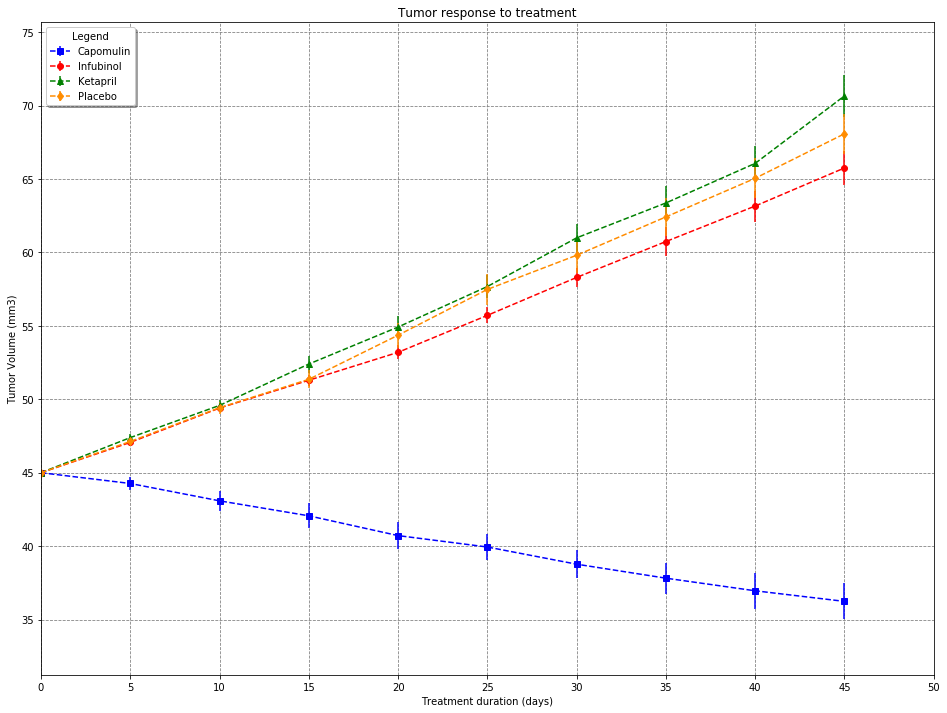

In [48]:
# Grab values for selected treatments
tumor_volume_avg_df = tumor_volume_avg_df[tumor_volume_avg_df["Drug"].isin(drug_list)]

min_value = tumor_volume_avg_df["Tumor Volume (mm3)"].min()
max_value = tumor_volume_avg_df["Tumor Volume (mm3)"].max()
colors = ["blue", "red", "green","darkorange"]
markers = ["s","o","^","d"]

plt.xlim(0, 50)
plt.ylim(min_value - 5,max_value +5)
plt.xlabel("Treatment duration (days)")
plt.ylabel("Tumor Volume (mm3)")
plt.title("Tumor response to treatment")

for i, drug in enumerate(tumor_volume_avg_df["Drug"].unique()):
    x = tumor_volume_avg_df[tumor_volume_avg_df["Drug"]==drug]["Timepoint"]
    y = tumor_volume_avg_df[tumor_volume_avg_df["Drug"]==drug]["Tumor Volume (mm3)"]
    e = tumor_volume_avg_df[tumor_volume_avg_df["Drug"]==drug]["Tumor Volume SE"]
    plt.errorbar(x, y, yerr = e, label = drug, marker = markers[i], color = colors[i], linestyle ="dashed")
             
plt.legend(loc="best", ncol=1, shadow=True, title="Legend", fancybox=True)
plt.grid(color='gray', linestyle='dashed')
plt.rcParams['axes.axisbelow'] = True
plt.rcParams["figure.figsize"] = [16,12]
plt.xticks(np.arange(min(x), max(x)+10, 5.0))
plt.show()

### Metastatic Sites changes over time per selected treatment

In [49]:
# Metastatic Sites changes over time per selected treatment
metastatic_avg_df = merge_df.groupby(["Drug", "Timepoint"], as_index = False)["Metastatic Sites"].agg(["mean","sem"])
metastatic_avg_df = pd.DataFrame(metastatic_avg_df).reset_index()
metastatic_avg_df=metastatic_avg_df.rename(columns = {"mean":"Metastatic Sites","sem":"Metastatic Sites SE"})

metastatic_avg_df.head()

,Drug,Timepoint,Metastatic Sites,Metastatic Sites SE
0,Capomulin,0,0.000000,0.000000
1,Capomulin,5,0.160000,0.074833
2,Capomulin,10,0.320000,0.125433
3,Capomulin,15,0.375000,0.132048
4,Capomulin,20,0.652174,0.161621


### Pivot table for metastatic changes over time for all trial treatments

In [50]:
pd.pivot_table(merge_df, index = ["Timepoint"], columns = ["Drug"], values = "Metastatic Sites", aggfunc = "mean")

Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.160000,0.380952,0.280000,0.304348,0.260870,0.375000,0.347826,0.120000,0.260870,0.166667
10,0.320000,0.600000,0.666667,0.590909,0.523810,0.833333,0.619048,0.250000,0.523810,0.500000
15,0.375000,0.789474,0.904762,0.842105,0.857143,1.250000,0.800000,0.333333,0.809524,0.809524
20,0.652174,1.111111,1.050000,1.210526,1.150000,1.526316,1.000000,0.347826,0.947368,1.294118
25,0.818182,1.500000,1.277778,1.631579,1.500000,1.941176,1.384615,0.652174,1.166667,1.687500
30,1.090909,1.937500,1.588235,2.055556,2.066667,2.266667,1.666667,0.782609,1.411765,1.933333
35,1.181818,2.071429,1.666667,2.294118,2.266667,2.642857,2.333333,0.952381,1.533333,2.285714
40,1.380952,2.357143,2.100000,2.733333,2.466667,3.166667,2.777778,1.100000,1.583333,2.785714


### Metastatic Sites changes over time for selected treatments including SE over mean; plot

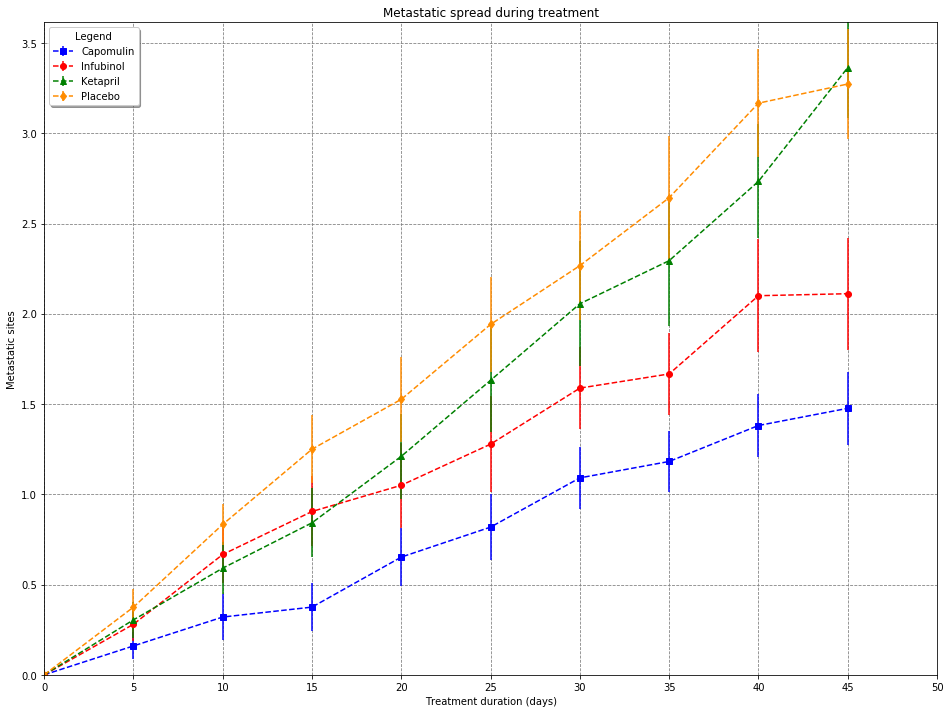

In [51]:
# Grab values for selected treatments
metastatic_avg_df = metastatic_avg_df[metastatic_avg_df["Drug"].isin(drug_list)]

max_value = metastatic_avg_df["Metastatic Sites"].max()
colors = ["blue", "red", "green","darkorange"]
markers = ["s","o","^","d"]

plt.xlim(0, 50)
plt.ylim(0, max_value + 0.25)
plt.xlabel("Treatment duration (days)")
plt.ylabel("Metastatic sites")
plt.title("Metastatic spread during treatment")

for i, drug in enumerate(metastatic_avg_df["Drug"].unique()):
    x = metastatic_avg_df[metastatic_avg_df["Drug"]==drug]["Timepoint"]
    y = metastatic_avg_df[metastatic_avg_df["Drug"]==drug]["Metastatic Sites"]
    e = metastatic_avg_df[metastatic_avg_df["Drug"]==drug]["Metastatic Sites SE"]
    plt.errorbar(x, y, yerr = e, label = drug, marker = markers[i], color = colors[i], linestyle ="dashed")
    #plt.plot(x, y, label = "",linestyle = '-')

plt.legend(loc="best", ncol=1, shadow=True, title="Legend", fancybox=True)
plt.grid(color='gray', linestyle='dashed')
plt.rcParams['axes.axisbelow'] = True
plt.rcParams["figure.figsize"] = [16,12]
plt.xticks(np.arange(min(x), max(x)+10, 5.0))
plt.show()

### Absolute survival rates per timepoint for all trial treatments

In [52]:
timepoint_df = merge_df.groupby(["Drug", "Timepoint"], as_index=False)["Mouse ID"].count()
timepoint_df = pd.DataFrame(timepoint_df)
timepoint_df = timepoint_df.rename(columns = {"Mouse ID":"Mouse Count"})
timepoint_df.head()

,Drug,Timepoint,Mouse Count
0,Capomulin,0,25
1,Capomulin,5,25
2,Capomulin,10,25
3,Capomulin,15,24
4,Capomulin,20,23


### Pivot table for absolute survival rates per timepoint for all trial treatments

In [53]:
pd.pivot_table(merge_df, index = ["Timepoint"], columns = ["Drug"], values = "Metastatic Sites", aggfunc = "count")

Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,25,25,25,25,25,25,24,25,24,25
5,25,21,25,23,23,24,23,25,23,24
10,25,20,21,22,21,24,21,24,21,22
15,24,19,21,19,21,20,15,24,21,21
20,23,18,20,19,20,19,15,23,19,17
25,22,18,18,19,18,17,13,23,18,16
30,22,16,17,18,15,15,12,23,17,15
35,22,14,12,17,15,14,9,21,15,14
40,21,14,10,15,15,12,9,20,12,14


In [54]:
# Relative survival rates per treatment per timepoint
timepoint_df["Survival rate (%)"] = 100*(1+(timepoint_df["Mouse Count"] - timepoint_df.iloc[0]["Mouse Count"]) / timepoint_df.iloc[0]["Mouse Count"])
timepoint_df.head()

,Drug,Timepoint,Mouse Count,Survival rate (%)
0,Capomulin,0,25,100.0
1,Capomulin,5,25,100.0
2,Capomulin,10,25,100.0
3,Capomulin,15,24,96.0
4,Capomulin,20,23,92.0


### Pivot table for relative survival rates per timepoint for all trial treatments

In [55]:
pd.pivot_table(timepoint_df, index = ["Timepoint"], values = "Survival rate (%)", columns = ["Drug"], aggfunc = "mean")

Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,100.0,100.0,100.0,100.0,100.0,100.0,96.0,100.0,96.0,100.0
5,100.0,84.0,100.0,92.0,92.0,96.0,92.0,100.0,92.0,96.0
10,100.0,80.0,84.0,88.0,84.0,96.0,84.0,96.0,84.0,88.0
15,96.0,76.0,84.0,76.0,84.0,80.0,60.0,96.0,84.0,84.0
20,92.0,72.0,80.0,76.0,80.0,76.0,60.0,92.0,76.0,68.0
25,88.0,72.0,72.0,76.0,72.0,68.0,52.0,92.0,72.0,64.0
30,88.0,64.0,68.0,72.0,60.0,60.0,48.0,92.0,68.0,60.0
35,88.0,56.0,48.0,68.0,60.0,56.0,36.0,84.0,60.0,56.0
40,84.0,56.0,40.0,60.0,60.0,48.0,36.0,80.0,48.0,56.0


### Survival rate plot

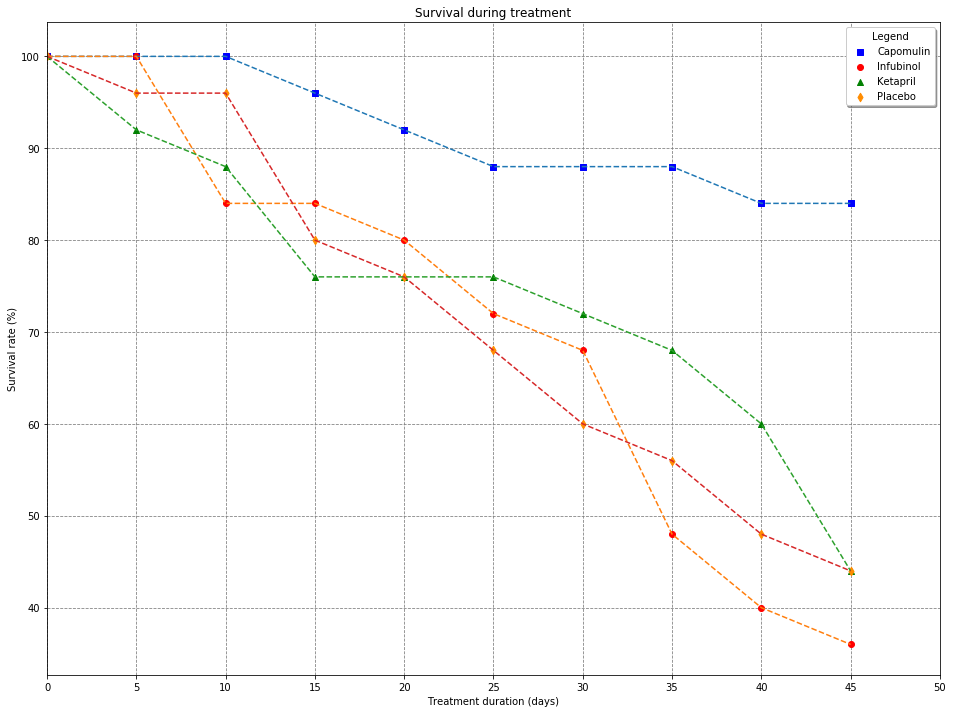

In [56]:
# Grab values for selected treatments
timepoint_df = timepoint_df[timepoint_df["Drug"].isin(drug_list)]

colors = ["blue", "red", "green","darkorange"]
markers = ["s","o","^","d"]

plt.xlim(0, 50)
plt.xlabel("Treatment duration (days)")
plt.ylabel("Survival rate (%)")
plt.title("Survival during treatment")

for i, drug in enumerate(timepoint_df["Drug"].unique()):
    x = timepoint_df[timepoint_df["Drug"]==drug]["Timepoint"]
    y = timepoint_df[timepoint_df["Drug"]==drug]["Survival rate (%)"]
    plt.scatter(x, y, label = drug, marker = markers[i], facecolors = colors[i])
    plt.plot(x, y, label ="", linestyle = 'dashed')

plt.legend(loc="best", ncol=1, shadow=True, title="Legend", fancybox=True)
plt.grid(color='gray', linestyle='dashed')
plt.rcParams['axes.axisbelow'] = True
plt.rcParams["figure.figsize"] = [12,9]
plt.xticks(np.arange(min(x), max(x)+10, 5.0))
plt.show()

### Tumor volume change per selected treatment

In [57]:
# Get the first and last value for number of mouses per treatment

vol_change_df =tumor_volume_avg_df.groupby("Drug")["Tumor Volume (mm3)"].agg(['first','last'])
vol_change_df = pd.DataFrame(vol_change_df).reset_index()
vol_change_df["Volume Change (%)"] = round(100*(vol_change_df["last"]-vol_change_df["first"])/vol_change_df["first"]).astype(int)
vol_change_df = vol_change_df.rename(columns = {"first":"Start volume","last":"End volume"})
vol_change_df

,Drug,Start volume,End volume,Volume Change (%)
0,Capomulin,45.0,36.236114,-19
1,Infubinol,45.0,65.755562,46
2,Ketapril,45.0,70.662958,57
3,Placebo,45.0,68.084082,51


### Tumor volume change per selected treatment; bar plot

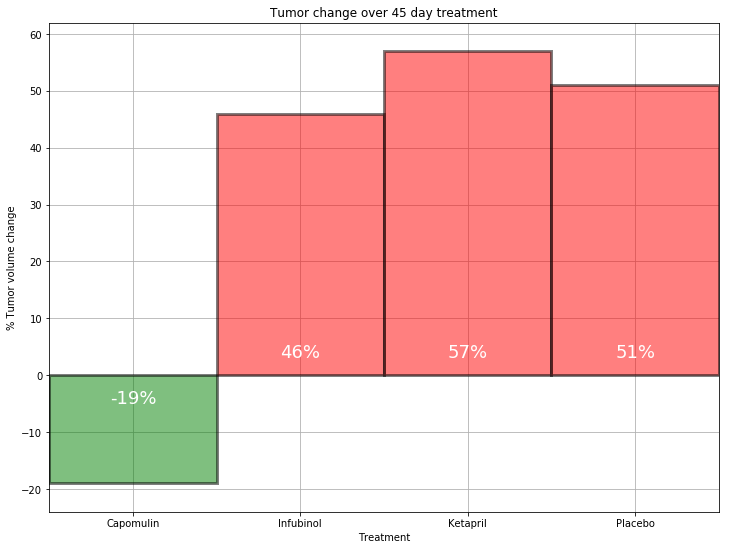

In [58]:
x_axis = np.arange(len(drug_list))
barcolor= ["red" if abs(perc) == perc else "green" for perc in vol_change_df["Volume Change (%)"]]
barwidth = 1

plt.bar(x_axis, vol_change_df["Volume Change (%)"], width = barwidth, color=barcolor,
        alpha=0.5, align="edge", edgecolor = "k", linewidth=3)

for i, (perc) in enumerate(vol_change_df["Volume Change (%)"]):
    plt.text(s = "{:.0%}".format(perc/100), x = i + 0.5*barwidth, y = np.sign(perc)*4,
             color = "w", ha = "center", va = "center", size=18)

tick_locations = [value+0.5 for value in x_axis]
plt.xticks(tick_locations, drug_list)
plt.grid()

plt.xlim(0, len(drug_list))
plt.ylim(min(vol_change_df["Volume Change (%)"]) - 5, max(vol_change_df["Volume Change (%)"]) + 5)

plt.title("Tumor change over 45 day treatment")
plt.xlabel("Treatment")
plt.ylabel("% Tumor volume change")
plt.rcParams["figure.figsize"] = [9,6]
plt.show()